# Detrend Data, Removing Annual Cycle

This tutorial shows how to detrend data

It is a commanly used technic to *detrend* data before doing further diagnosis, this tutorials shows how to do so using [CDAT](https://cdat.llnl.gov)

© Software was developed by Charles Doutriaux and CDAT team, and tutorial was written by Charles Dutriaux. (14 Nov. 2018)



## Contents: 
([Top](#top))
- [Prepare Notebook and Data](#nb)
- [Removing annual cycle](#ac)
- [Detrend](#detrend)

## Prepare Notebook and Data<a id='nb'></a>

In [1]:
from __future__ import print_function
import cdms2
import MV2
import genutil
import cdutil
import vcs
import os
import requests

# This is a subset over North America
filename = 'tas_Amon_IPSL-CM5A-LR_1pctCO2_r1i1p1_185001-198912.nc'
if not os.path.exists(filename):
    r = requests.get("https://cdat.llnl.gov/cdat/sample_data/notebooks/{}".format(filename), stream=True)
    with open(filename,"wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:  # filter local_filename keep-alive new chunks
                f.write(chunk)


f = cdms2.open(filename)

data = f("tas")

Now to demonstrate `genutil` capabilities and highlight some scientific points about operations order, let's mask some data and compute the time serie

In [2]:
# Mask data where greater than maximum less 2 K
data = MV2.masked_greater(data, data.max()-2)

# Time series
data_ts = genutil.averager(data, axis='xy')

/Users/doutriaux1/miniconda3/envs/vcs/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/doutriaux1/miniconda3/envs/vcs/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


Let's take a look at time serie and note the trend and annual cycle

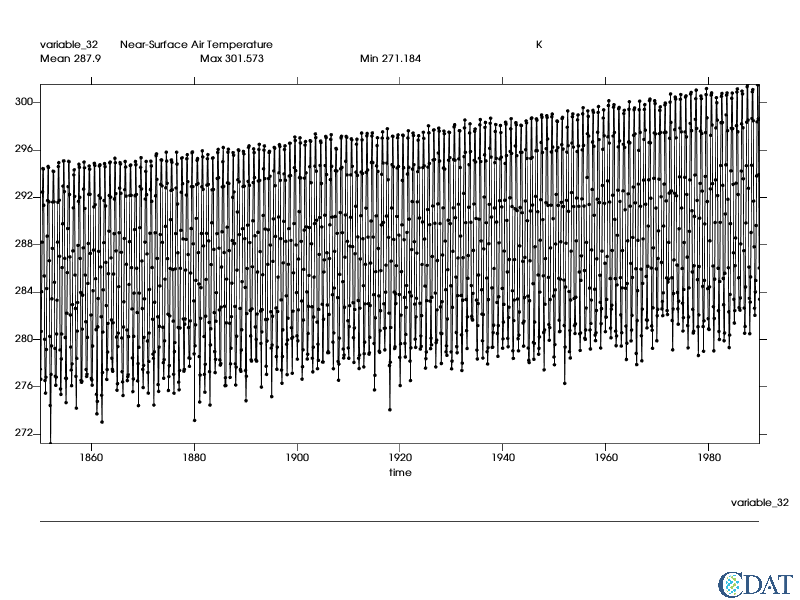

In [3]:
x = vcs.init(bg=True, geometry=(800,600))
line = vcs.create1d()
line.markersize = .5
x.plot(data_ts, line)

## Removing Annual Cycle <a id='ac'></a>

First we will remove the annual cycle for these **monthly** data. Because it is masked order matter as we will demo.

In [4]:
data_departures = cdutil.times.ANNUALCYCLE.departures(data)
data_departures_ts = genutil.averager(data_departures, axis='xy')
data_ts_departures = cdutil.times.ANNUALCYCLE.departures(data_ts)

Notice how the trends shows up much nicer now!

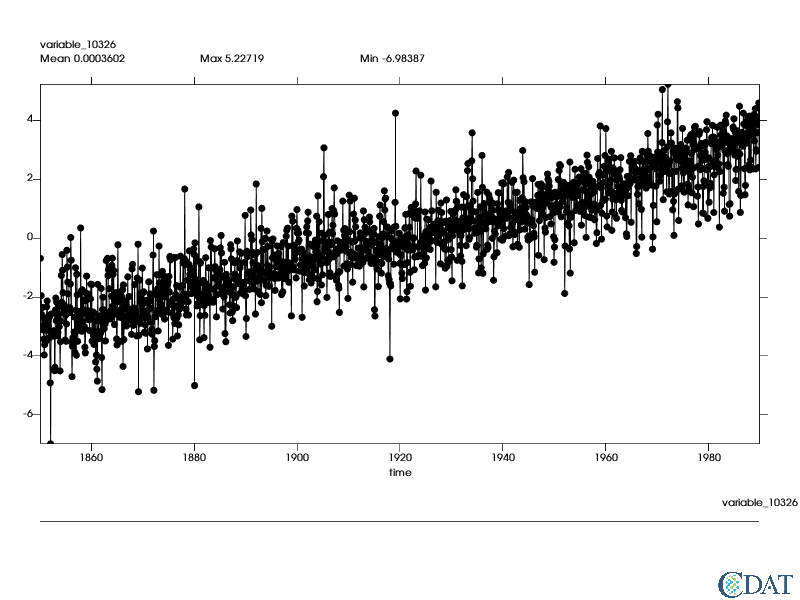

In [5]:
x.clear()
x.plot(data_departures_ts)

Note please note the importance of order operation when missing data is present both time series are slightly different and the later years (where missing data occurs)

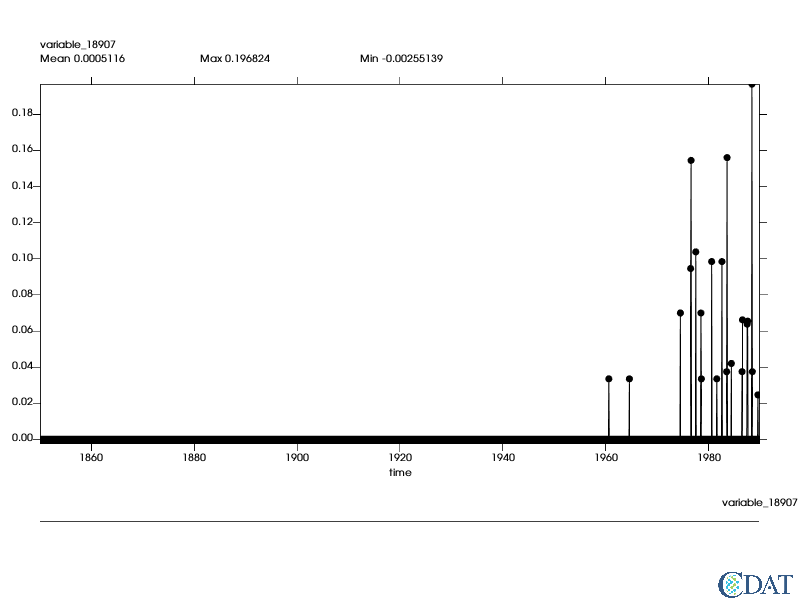

In [6]:
x.clear()
x.plot(data_departures_ts - data_ts_departures)

## Detrend Data<a id='detrend'></a>

First we will compute the trend, other `time` note that the index of time can be anything, `genutil` will determine its index.

After computation we lose the time axis, also note the units, based on units on time axis, since units are in `days since XXX` the coeef/trend is in `K/day`

In [7]:
coeff, intercept = genutil.statistics.linearregression(data_departures, axis="t")
print("Shapes: coeff {}, intercept {}".format(coeff.shape, intercept.shape))
# Let's do the same for the time serie
coeff_ts, intercept_ts = genutil.statistics.linearregression(data_departures_ts, axis="t")

Shapes: coeff (13, 16), intercept (13, 16)


Now let's actually remove the trend
We will need

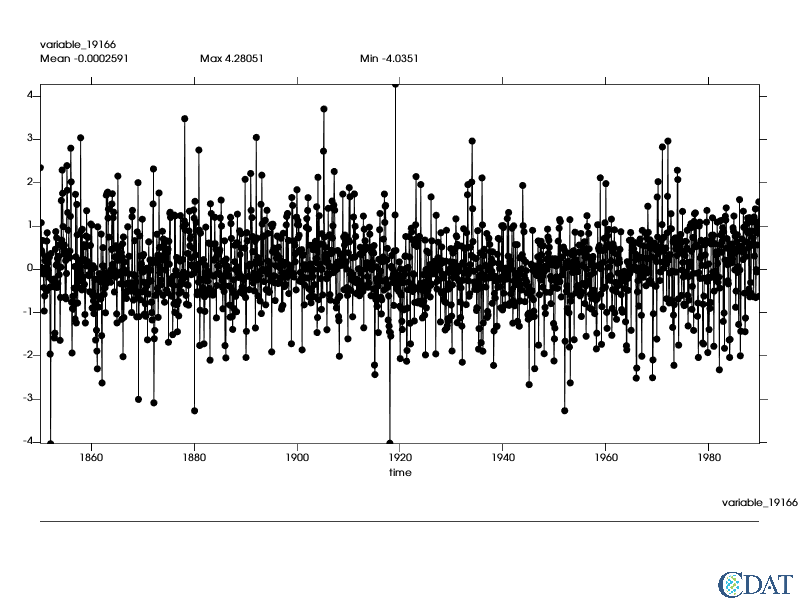

In [8]:
times = MV2.array(data.getTime()[:])
times.setAxis(0, data.getTime())

# since time is not necessarily on index 0 we need to use the grower function
# we use data as first argument to ensure same order
tmp, full_times = genutil.grower(data_departures, times)
# same for cefficient
tmp, coeff = genutil.grower(data, coeff)
# same for intercept
tmp, intercept = genutil.grower(data, intercept)

data_departures_detrend = data_departures - full_times * coeff - intercept
data_departures_ts_detrend = data_departures_ts - times * coeff_ts - intercept_ts
x.clear()
x.plot(data_departures_ts_detrend)

Here again the order matters

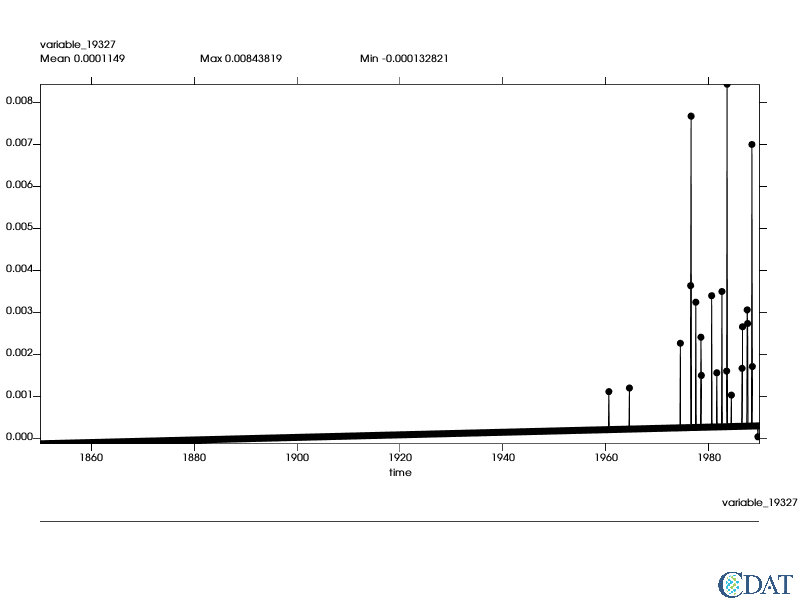

In [9]:
data_departures_detrend_ts = genutil.averager(data_departures_detrend, axis='xy')

x.clear()
x.plot(data_departures_detrend_ts - data_departures_ts_detrend)